In [1]:
import scipy.spatial as spatial
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import powerset
import mpl_toolkits.mplot3d as a3
from wireframes import wireframe_sphere
from rich import print
from itertools import combinations

In [2]:
X = np.random.rand(4,3)

In [3]:
def cayley_menger_matrix(X):
    d = X.shape[1]
    dm = np.power(spatial.distance_matrix(X,X), 2)
    m = np.zeros(np.asarray(dm.shape) + 1)
    m[:,0] = 1
    m[0,:] = 1
    m[0,0] = 0
    m[1:,1:] = dm
    return m

The Cartesian coordinates of any point are a weighted average
of the Cartesian coordinates of the triangle's vertices,
with the weights being the point's barycentric coordinates summing to unity. So e.g. for a triangle:
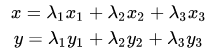

-- for plotting tetrahedrons:
         "you draw a point by drawing a point"
         "you draw a line by connecting its points"
         "you draw a triangle by connecting its lines"
         "you draw a tetrahedron by connecting its triangles"
         "you draw a 4-simplex by connecting its tetrahedrons"
        .... etc.

<IPython.core.display.Javascript object>


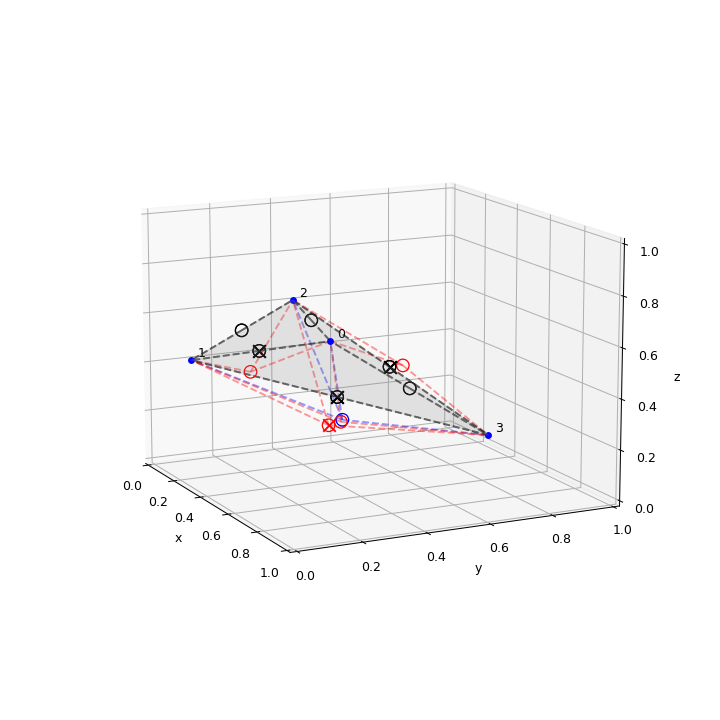

(2, 3)

(0, 1)

(0, 1)

(3, 1)

(2, 3, 1)

(2, 3)

(3, 1)

In [4]:
%matplotlib notebook
tet = spatial.Delaunay(X)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = "3d")

tri = list()
kdtree = spatial.KDTree(X) # X is in R^d
cech_complex = set()

def cech(kdtree, simplex, parent_value = None, ax = None):
    X = kdtree.data
    if len(simplex) == 0:
        return {}
    elif len(simplex) == 1:
        return {(simplex, 0.0)}
    
    # https://westy31.home.xs4all.nl/Circumsphere/ncircumsphere.htm
    content_inv = np.linalg.inv(cayley_menger_matrix( X[simplex,:] ))
    circumradius = np.sqrt(content_inv[0,0]/-2)
    circumcentre = content_inv[1:,0].dot( X[simplex,:] )
    
    # a face is Gabriel if there are no other vertices within the d-ball
    _,nn = kdtree.query(circumcentre, k = len(simplex))
    assert len(nn) >= len(simplex)
    
    if set(nn) != set(simplex):
        F = { (tuple(simplex), parent_value) }
        print(simplex)
        #F = { (tuple(simplex), circumradius) }
    else:
        F = { (tuple(simplex), circumradius) }
    
    #---- Plotting
    if ax is not None:
        plot_color = { 2 : "black", 3 : "red", 4 : "blue" }
        plot_color = plot_color[len(simplex)]
        ax.scatter(*tuple(circumcentre), color = plot_color, marker = "o", facecolors='none', s = 100, alpha = 1)
        for y in X[simplex, :]:
            ax.plot(
                [circumcentre[0],y[0]],
                [circumcentre[1],y[1]],
                [circumcentre[2],y[2]],
                "--",
                color = plot_color,
                alpha = 0.4
            )
        if set(nn) != set(simplex):
            ax.scatter(
                *tuple(circumcentre),
                color = plot_color,
                marker = "x",
                s = 100,
                alpha = 1
            )
    
    #----- Recurse
    sub = combinations(simplex, len(simplex)-1)
    for f in sub:
        F = F.union(cech(
            kdtree = kdtree,
            simplex = f,
            parent_value = circumradius,
            ax = ax
        ))
    return F

for t in tet.simplices:
    for f in combinations(t, 3):
        tri.append(f)
        
    cech_complex = cech_complex.union(cech(
        kdtree = kdtree,
        simplex = t,
        ax = ax
    ))

cech_complex = list(cech_complex)
plt_tri = a3.art3d.Poly3DCollection(X[tri, :])
plt_tri.set_alpha(0.1)
plt_tri.set_color('grey')
ax.add_collection3d(plt_tri)

for i,x in enumerate(X):
    ax.scatter(*tuple(x), color = "blue")
    ax.text(*tuple(x+0.015), str(i))
    
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [5]:
print(len(cech_complex))
print(sorted(cech_complex, key = lambda t: t[1]))

18

[
    ((1,), 0.0),
    ((2,), 0.0),
    ((3,), 0.0),
    ((0,), 0.0),
    ((0, 2), 0.16088733958378415),
    ((2, 1), 0.2063275174415197),
    ((0, 3), 0.29221246791054284),
    ((0, 1), 0.3097319129339682),
    ((0, 2, 1), 0.3097319129339682),
    ((0, 2, 3), 0.41810379857849717),
    ((2, 3), 0.41810379857849717),
    ((2, 3), 0.49076126016947447),
    ((3, 1), 0.49076126016947447),
    ((0, 1), 0.5027664511829046),
    ((0, 3, 1), 0.5027664511829046),
    ((3, 1), 0.5027664511829046),
    ((0, 2, 3, 1), 0.5028772728335105),
    ((2, 3, 1), 0.5028772728335105)
]

In [6]:
import gudhi as gd
skeleton = gd.AlphaComplex(
    points = X
)
st = skeleton.create_simplex_tree()
gudhi_cech_complex = list(map(lambda t : (t[0],np.sqrt(t[1])), st.get_filtration()))
print(len(gudhi_cech_complex))
print(sorted(gudhi_cech_complex, key = lambda t : t[1]))

15

[
    ([0], 0.0),
    ([1], 0.0),
    ([2], 0.0),
    ([3], 0.0),
    ([1, 2], 0.16088733958378415),
    ([0, 1], 0.2063275174415197),
    ([2, 3], 0.29221246791054284),
    ([0, 2], 0.30973191293396823),
    ([0, 1, 2], 0.30973191293396823),
    ([1, 3], 0.41810379857849717),
    ([1, 2, 3], 0.41810379857849717),
    ([0, 3], 0.5027664511829046),
    ([0, 2, 3], 0.5027664511829046),
    ([0, 1, 3], 0.5028772728335105),
    ([0, 1, 2, 3], 0.5028772728335105)
]

In [7]:
print(spatial.distance_matrix(X,X)/2)

[[0.         0.29630104 0.16088734 0.29221247]
 [0.29630104 0.         0.20632752 0.47719004]
 [0.16088734 0.20632752 0.         0.38478166]
 [0.29221247 0.47719004 0.38478166 0.        ]]